<a href="https://colab.research.google.com/github/JanMikicki/albedo-prediction/blob/main/mercury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jan Mikicki - Task 2 for "Macgine Learning Model for the Planetary Albedo" project

---

The overall idea was to use a similar model as was used in Task 1, but this time reverse the input and output data dimensions, i.e provide albedo data as input and get chemical data as output.

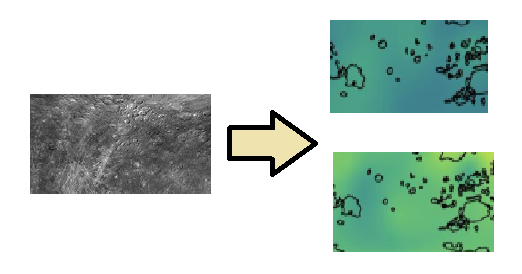

Unfortunately I think had some issues in fullt understanding the task which are expressed later.

In [ ]:
! git clone https://github.com/ML4SCI/ML4SCI_GSoC.git
! pip install albumentations==0.4.6

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import shutil
import os
from skimage.transform import resize

In [4]:
albedo_top_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Mercury/mercury-albedo-top-half.png.csv', delimiter=',')
albedo_bottom_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Mercury/mercury-albedo-resized-bottom-half.png.csv', delimiter=',')
alsi_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Mercury/alsimap_smooth_032015.png.csv', delimiter=',')
casi_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Mercury/casimap_smooth_032015.png.csv', delimiter=',')
fesi_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Mercury/fesimap_smooth_032015.png.csv', delimiter=',')
mgsi_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Mercury/mgsimap_smooth_032015.png.csv', delimiter=',')
ssi_data  = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Mercury/ssimap_smooth_032015.png.csv', delimiter=',')

In [6]:
data_arr = [albedo_top_data, albedo_bottom_data, alsi_data, 
            casi_data, fesi_data, mgsi_data, ssi_data]

print("Max")
print([x.max() for x in data_arr])
print("Min")
print([x.min() for x in data_arr])

print("Sizes")
print([x.shape for x in data_arr])

Max
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Sizes
[(720, 1440), (720, 1440), (720, 1440), (720, 1440), (720, 1440), (720, 1440), (720, 1440)]


Original images:


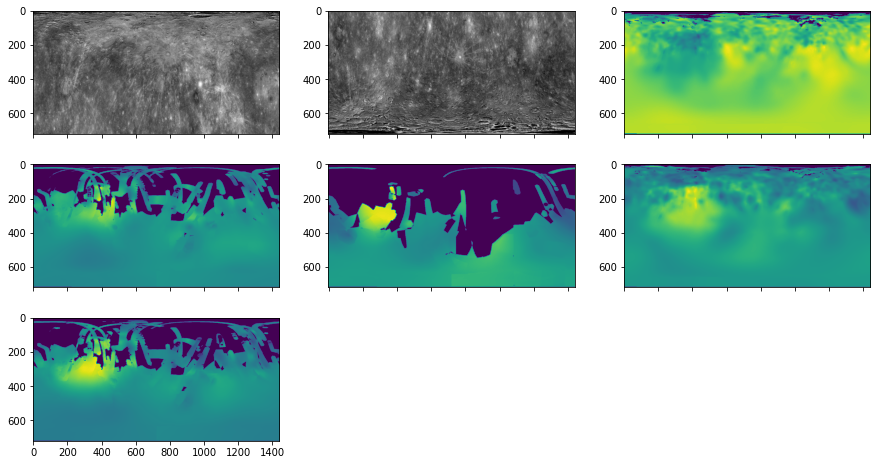

In [ ]:
%matplotlib inline

print("Original images:")

fig, axs = plt.subplots(3, 3, sharex=True, figsize=(15,8))

axs[0, 0].imshow(data_arr[0], cmap='gray')
axs[0, 1].imshow(data_arr[1], cmap='gray')
axs[0, 2].imshow(data_arr[2])
axs[1, 0].imshow(data_arr[3])
axs[1, 1].imshow(data_arr[4])
axs[1, 2].imshow(data_arr[5])
axs[2, 0].imshow(data_arr[6])
axs[2, 1].axis('off')
axs[2, 2].axis('off')
plt.show()

The task description sounds a little bit contradictory to me. 

It says we should predict the chemical composition based on the albedo data and that we should try to fill the gaps in chemical composition data. However it also says that the model should be trained on the top half of the surface, where most of these mapping gaps occur (some example images in task description show that the element/chemical maps span [-90, 90] latitude, so only the top halves in the corresponding images above respresent the upper part of the planet). 

In my understanding, it would make more sense if the model was trained on the bottom half of the planet, (where chemical data is mostly complete) and then it tried to predict the gaps in the upper half, not the other way around.

The way it is now, only a small training area is left to use, where all elements are mapped, as shown below.

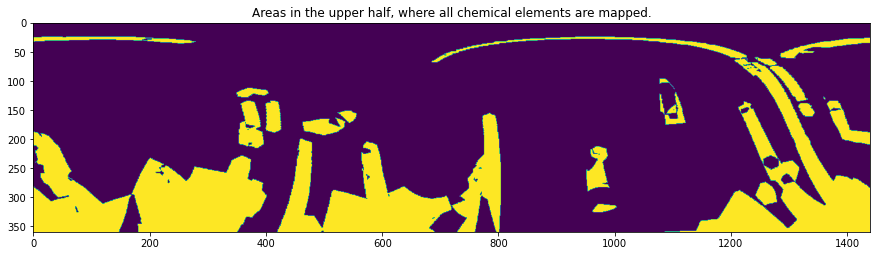

In [7]:
nonempty = np.zeros_like(data_arr[4][:360, :])
nonempty_idxs = np.where(np.logical_and.reduce((data_arr[2][:360, :] > 0., 
                                                data_arr[3][:360, :] > 0., 
                                                data_arr[4][:360, :] > 0.,
                                                data_arr[5][:360, :] > 0., 
                                                data_arr[6][:360, :] > 0.)))
nonempty[nonempty_idxs] = 1

plt.figure(figsize=(15, 15))
plt.title("Areas in the upper half, where all chemical elements are mapped.")
plt.imshow(nonempty)
plt.show()

Still, because the task description explicitly says that the model should be trained on the top half, I did attempt to do so. I didn't have a good idea how to fragment the training space (visible above in yellow) into even square chunks that could be fed as a training data. Perhaps some of them could be extracted by hand, but preferably many training examples should be extracted to make the training set as diverse as possible.

Another idea I had was to try and predict each pixel individually. In other words, each pixel would be an individual data point in contrast to some square portion of the image. It is relatively simple to sample just a single pixel from a yellow area above, instead of finding a square area that fits inside.

That solution has many drawbacks though. Because each pixel is predicted individually, the receptive field aspect of conv-nets is lost. Each value is predicted in seperation without "knowing" anything about neighboring pixels.

Still, this is the solution I went with in this notebook.

In [ ]:
"""
Create a Dataset object which samples a random pixel cooridinate, where all 
elements are present, and then returns the corresponding datapoints in these 
coordinates for both albedo and all elements.
"""

class MapDataset(Dataset):
    def __init__(self, half):
        self.half = half
        if half == "top":
            self.albedo = resize(data_arr[0], (360, 1440))
            self.a = data_arr[2][:360, :]
            self.b = data_arr[3][:360, :]
            self.c = data_arr[4][:360, :]
            self.d = data_arr[5][:360, :]
            self.e = data_arr[6][:360, :]

            nonzero_idxs = np.nonzero(nonempty)
            self.nonzero_rows = nonzero_idxs[0]
            self.nonzero_cols = nonzero_idxs[1]
        elif half == 'bottom':
            self.albedo = resize(data_arr[1], (360, 1440))
            self.a = data_arr[2][360:, :]
            self.b = data_arr[3][360:, :]
            self.c = data_arr[4][360:, :]
            self.d = data_arr[5][360:, :]
            self.e = data_arr[6][360:, :]

    def __len__(self):
        return len(np.nonzero(nonempty)[0]) if self.half == 'top' else 360*1440

    def __getitem__(self, index):

        if self.half == 'top':
            randidx = np.random.randint(low=0, high=len(self.nonzero_rows))
            pix_row = self.nonzero_rows[randidx]
            pix_col = self.nonzero_cols[randidx]
        else:
            pix_row = np.random.randint(low=0, high=360)
            pix_col = np.random.randint(low=0, high=1440)

        albedo = self.albedo[pix_row, pix_col]
        a = self.a[pix_row, pix_col]
        b = self.b[pix_row, pix_col]
        c = self.c[pix_row, pix_col]
        d = self.d[pix_row, pix_col]
        e = self.e[pix_row, pix_col]

        # combine all chemical pictures into (4, h, w) input array
        output = np.dstack((a, b, c, d, e)).transpose(2, 0, 1)

        #return input_image, target_image
        return torch.from_numpy(np.array([albedo])).unsqueeze(0).unsqueeze(0), torch.from_numpy(output)

dataset = MapDataset(half="bottom")
loader = DataLoader(dataset, batch_size=1)

for x, y in loader:
    print(x)
    print(x.size())
    print(y.size())
    break

tensor([[[[0.3409]]]], dtype=torch.float64)
torch.Size([1, 1, 1, 1])
torch.Size([1, 5, 1, 1])


In [ ]:
"""
GAN Discriminator
"""

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 1, stride,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                6,
                features[0],
                kernel_size=1,
                stride=1,
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=1, stride=1
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [ ]:
def test_discriminator():
    x = torch.randn((1, 1, 1, 1))
    y = torch.randn((1, 5, 1, 1))
    model = Discriminator(in_channels=1)
    preds = model(x, y)
    #print(model)
    print(preds.shape)

test_discriminator()

torch.Size([1, 1, 1, 1])


In [ ]:
"""
GAN Generator
"""

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 1)
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 1),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.bottleneck = nn.Sequential(nn.Conv2d(features * 8, features * 8, kernel_size=1),
                                        nn.ReLU()
                                        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Blockfeatures * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=1, stride=1),
            #nn.Tanh(),
            nn.Sigmoid(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [ ]:
def test_generator():
    x = torch.randn((1, 1, 1, 1))
    model = Generator(in_channels=1, out_channels=5, features=64)
    preds = model(x)
    print(preds.shape)

test_generator()

torch.Size([1, 5, 1, 1])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Assigned device: ", device)

def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler=0, d_scaler=0,
):
    loop = tqdm(loader, position=0, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(device)
        y = y.to(device)
        
        # Train Discriminator
        y_fake = gen(x)
        D_real = disc(x, y)
        D_real_loss = bce(D_real, torch.ones_like(D_real))
        D_fake = disc(x, y_fake.detach())
        D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        # Train generator
        D_fake = disc(x, y_fake)
        G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
        L1 = l1_loss(y_fake, y) * 100
        G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

Assigned device:  cuda


In [ ]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr, device):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
def learn(gen_lr, disc_lr, batch_size, epochs, save=True, load=False, gen_path="", disc_path="",):
    
    disc = Discriminator(in_channels=1).double().to(device)
    gen = Generator(in_channels=1, out_channels=5, features=64).double().to(device)
    opt_disc = optim.Adam(disc.parameters(), lr=disc_lr, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if load:
        load_checkpoint(
            gen_path, gen, opt_gen, lr,
        )
        load_checkpoint(
            disc_path, disc, opt_disc, lr,
        )

    train_dataset = MapDataset(half="top")
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )


    val_dataset = MapDataset(half="bottom")
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    for epoch in range(epochs):
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE)
    
    save_checkpoint(gen, opt_gen, filename=f"gen_checkpoint_final")
    save_checkpoint(disc, opt_disc, filename=f"disc_checkpoint_final")

In [ ]:
"""
Train the model on all pixels
"""
learn(gen_lr=0.0001, disc_lr=0.0004, batch_size=64, epochs=1)

100%|██████████| 1790/1790 [03:11<00:00,  9.35it/s, D_fake=0.382, D_real=0.774]


=> Saving checkpoint
=> Saving checkpoint


In [ ]:
"""
Load the resulting model and infer all pixels for top half of the planet.
"""

top_albedo = np.asarray(resize(data_arr[0], (360, 1440)))

out_1 = np.zeros_like(top_albedo)
out_2 = np.zeros_like(top_albedo)
out_3 = np.zeros_like(top_albedo)
out_4 = np.zeros_like(top_albedo)
out_5 = np.zeros_like(top_albedo)

gen = Generator(in_channels=1, out_channels=5, features=64).double()
checkpoint = torch.load("gen_checkpoint_final", map_location=torch.device('cpu'))
gen.load_state_dict(checkpoint["state_dict"])
gen.eval()

In [ ]:
rows = 360
cols = 1440

with torch.no_grad():
    for x in range(0, rows):
        for y in range(0, cols):
            input = torch.from_numpy(np.array([top_albedo[x, y]])).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            preds = gen(input)
            out_1[x, y] = preds[:, 0, :, :].item()
            out_2[x, y] = preds[:, 1, :, :].item()
            out_3[x, y] = preds[:, 2, :, :].item()
            out_4[x, y] = preds[:, 3, :, :].item()
            out_5[x, y] = preds[:, 4, :, :].item()

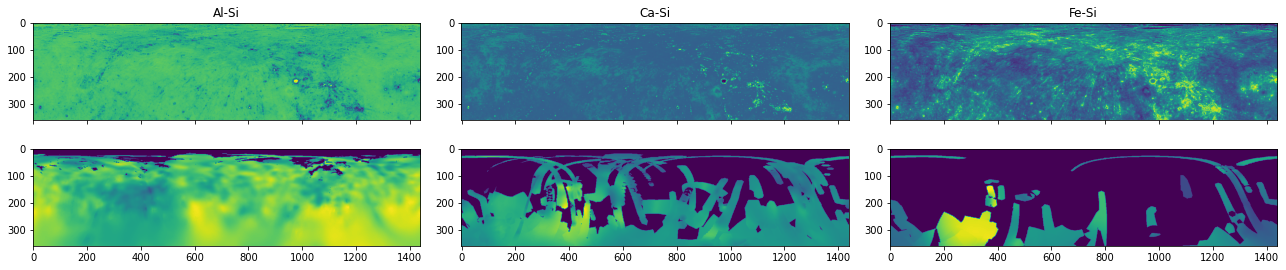

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, figsize=(18,4))

axs[0, 0].imshow(out_1)
axs[0, 1].imshow(out_2)
axs[0, 2].imshow(out_3)
axs[1, 0].imshow(data_arr[2][:360, :])
axs[1, 1].imshow(data_arr[3][:360, :])
axs[1, 2].imshow(data_arr[4][:360, :])

axs[0, 0].set_title("Al-Si")
axs[0, 1].set_title("Ca-Si")
axs[0, 2].set_title("Fe-Si")

plt.tight_layout()
plt.show()

The results differ visibly from real images, even in the mapped/training areas. Even though the model learned to mimic the overall value (color) of the map for each element, the results still look more like the albedo map. For example, many craters are visible in predicted chemical composition maps but they are not visible in real mapping data.

This is because of the selected approach of predicting each pixel individualy.
Because of thet the model maps the albedo data one to one.

In [ ]:
"""
Infer all pixels for bottom half of the planet.
"""

bottom_albedo = np.asarray(resize(data_arr[1], (360, 1440)))

outb_1 = np.zeros_like(top_albedo)
outb_2 = np.zeros_like(top_albedo)
outb_3 = np.zeros_like(top_albedo)
outb_4 = np.zeros_like(top_albedo)
outb_5 = np.zeros_like(top_albedo)

rows = 360
cols = 1440

with torch.no_grad():
    for x in range(0, rows):
        for y in range(0, cols):
            input = torch.from_numpy(np.array([bottom_albedo[x, y]])).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            preds = gen(input)
            outb_1[x, y] = preds[:, 0, :, :].item()
            outb_2[x, y] = preds[:, 1, :, :].item()
            outb_3[x, y] = preds[:, 2, :, :].item()
            outb_4[x, y] = preds[:, 3, :, :].item()
            outb_5[x, y] = preds[:, 4, :, :].item()

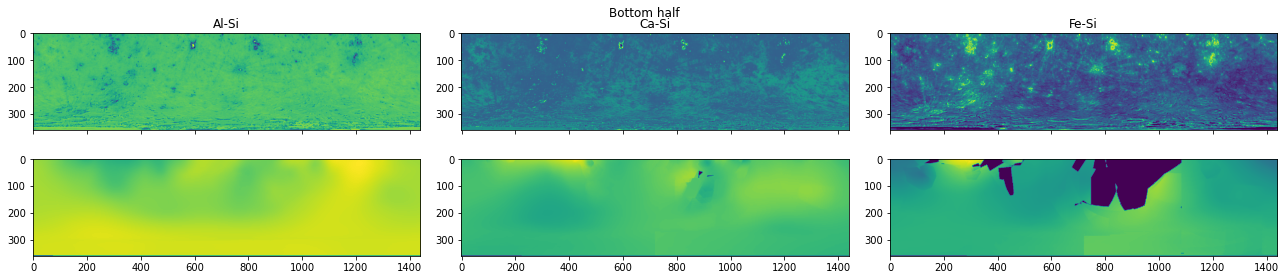

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, figsize=(18,4))

fig.suptitle('Bottom half')
axs[0, 0].imshow(outb_1)
axs[0, 1].imshow(outb_2)
axs[0, 2].imshow(outb_3)
axs[1, 0].imshow(data_arr[2][360:, :])
axs[1, 1].imshow(data_arr[3][360:, :])
axs[1, 2].imshow(data_arr[4][360:, :])

axs[0, 0].set_title("Al-Si")
axs[0, 1].set_title("Ca-Si")
axs[0, 2].set_title("Fe-Si")


plt.tight_layout()
plt.show()

Once again, even thoug the model learned the overall color for the elemetns, many of the nuances are carried on from the albedo.

It didn't make much sense to compare the images where the original had many gaps (like Fe-Si) so I compared histograms for Al-Si and Ca-Si for the bottom halves, as seen below.

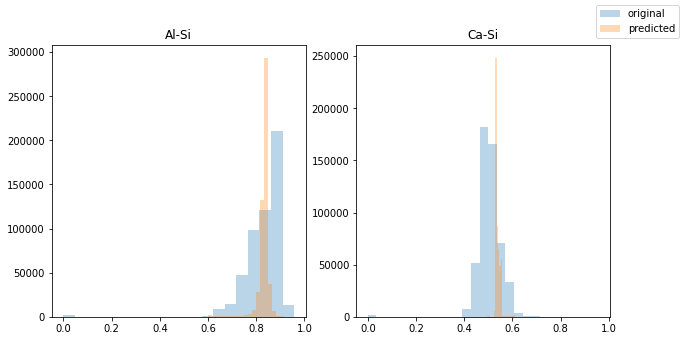

In [ ]:
"""
Check the histograms for bottom half.
"""
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,5))

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=20)

axs[0].hist(data_arr[2][360:, :].flatten(), label='original', **kwargs)
axs[0].hist(outb_1.flatten(), label='predicted', **kwargs)
axs[0].set_title("Al-Si")

axs[1].hist(data_arr[3][360:, :].flatten(), **kwargs)
axs[1].hist(outb_2.flatten(), **kwargs)
axs[1].set_title("Ca-Si")

fig.legend()
plt.show()

Once again, the results are visibly different from the originals. It is believed that the results would improve if the model was trained on patches of images instead of single pixels. To do that however, more traing area should be available, either by including a bottom part of the planet or by devsing some clever way to extract a large amount of fully mapped image patches from the top half.